# BM 336027 - Technion - Medical Image Processing


## Homework 2 - Edge Detection & Hough Transform 
---

### <a style='color:red'> Due Date: 7.12.2022 
</a>

---
###  Agenda

* [Exercise 0: Gaussian Filter](#Exercise-0)
* [Exercise 1: Canny Edge Detection](#Exercise-1)
* [Exercise 2: Hough Transform](#Exercise-2)

#### Use as many cells as you need

In [1]:
# imports you will need
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from typing import Tuple
import cv2
%matplotlib inline

---

### **Assignment Instructions**
**In this assignment, you are allowed to use only basic numpy and matplotlib functions, and functions you implemented in other sections of the exercises (unless otherwise instructed)**

---

###  Exercise 0

In many cases, you might want to blur your image before using algorithms to process it.  
A good kernel you can use to blur an image is the Gaussian kernel.  
Implement a function `gaussian_kernel` that returns a Gaussian kernel for a given kernel size and std.
Write a description of your function and explain its inputs and output.

In [2]:
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    '''
    The function gets a kernel size and std value and returns a Gaussian kernel.

    :param size: the size of the kernel [size, size]
    :param sigma: the std value
    :return gauss_kernel: 2d array of a gaussian kernel
    '''
    # ====== YOUR CODE: ======
    center = np.median(range(size))
    gauss_kernel = np.zeros([size, size])

    x = np.arange(size)
    rows, cols = np.meshgrid(x, x)
    dist_sum = np.square(rows - center) + np.square(cols - center)
    gauss_kernel = (np.exp(-(dist_sum)/(2*np.square(sigma)))) / (2*np.pi*np.square(sigma)) 
    # ========================
    return gauss_kernel

###  Exercise 1

In this exercise, we'll Implement the Canny edge detector.  

1. First, we need to get the image gradients.  
   Implement the function `img_grad_sobel` that calculates the image gradient magnitude and direction. This function should return two arrays; one of the gradient magnitude and another of the gradient direction in radians. The gradient maps should have the same size as the input.  <br>
    Note: to avoid producing edges at the image's borders, use the reflection boundary condition.<br>
    You may use the `convolve2d` function of the scipy.signal package.  
    Write a description of your function and explain its inputs and output. 

 

In [3]:
def img_grad_sobel(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''
    This function gets an image and cslculates its gradient magnitude and direction.

    :param img: original image
    :return magnitude: array of the gradient magnitude [img size]
    :return direction: array of the direction magnitude in radians [img size]
    '''
    # ====== YOUR CODE: ======
    dfx = np.array([[1, 0 , -1],[2, 0, -2], [1, 0, -1]]) 
    dfy = np.array([[1, 2 , 1],[0, 0, 0], [-1, -2, -1]])  
    
    fx = signal.convolve2d(img, dfx, boundary='symm', mode='same')
    fy = signal.convolve2d(img, dfy, boundary='symm', mode='same')
    
    magnitude = np.sqrt(fx**2 + fy**2)
    direction = np.arctan2(fx, fy)
    # ========================
    
    return magnitude, direction

2. Load the image 'brain.jpg' and display it in one figure before and after using your function and add titles. <br>
The image might contain noise. Use the Gaussian kernel from exercise 0 and convolve it with the image to produce a cleaner image. Experiment to find good parameters for this operation.
Do not blur the image too much.

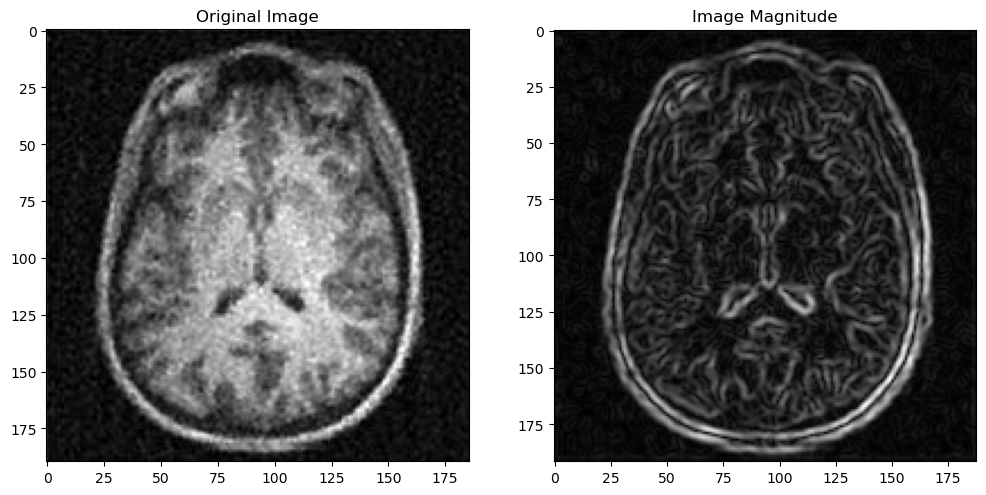

In [4]:
# ====== YOUR CODE: ======
img = plt.imread('images/brain.jpg')
blured_img = signal.convolve2d(img, gaussian_kernel(3, 3))
img_magnitude, img_direction = img_grad_sobel(blured_img)

# Display
titles = ['Original Image', 'Image Magnitude']
disp_img = [img, img_magnitude]

plt.figure(figsize=(12,12))
for i in range(2):
  plt.subplot(1, 2, i+1), plt.imshow(disp_img[i], cmap='gray'), plt.title(titles[i])

plt.show()
# ========================

3. The gradient magnitude of the blurred image contains thick blurred edges.   
We would like to make the edges in the gradient map thinner.   
Implement the function `non_max_suppression` that takes in a gradient image and extracts thin edges using non-maximum suppression.  
Your function has to go over all the pixels in the image and replace with 0 the pixels whose neighbors in the gradient direction have higher values. You can assume a neighborhood of 3x3. 
Since the edges of the image might not have a pixel to compare, you can change those pixels to 0.  
Write a description of your function and explain its inputs and output.

In [5]:
def non_max_suppression(mag: np.ndarray, angle2: np.ndarray) -> np.ndarray:
    '''
    This function gets a gradient image, go over all pixels and reset those who
     have neighbors in their gradient direction with higher values.
    
    :param grad_magnitude: array of gradient magnitude map of an image
    :param grad_direction: array of gradient direction map of an image [radians]
    :return non_max: array of an image without thin edges
    '''
    # ====== YOUR CODE: ======
    non_max = np.zeros_like(mag)

    for i in range(1, mag.shape[0]- 1):
        for j in range(1, mag.shape[1]- 1):
             
            if angle2[i][j] < 0:
                angle2[i][j] += np.pi

            # 45 degrees    
            if ((1/8)*np.pi < angle2[i][j] <= (5/8)*np.pi):
                nibr_pix_1, nibr_pix_2 = mag[i-1][j-1], mag[i+1][j+1]

            # 90 degrees    
            elif ((3/8)*np.pi < angle2[i][j] <= (5/8)*np.pi):
                nibr_pix_1, nibr_pix_2 = mag[i][j-1], mag[i][j+1]

            # 135 degrees    
            elif ((5/8)*np.pi < angle2[i][j] < (7/8)*np.pi):
                nibr_pix_1, nibr_pix_2 = mag[i+1][j-1], mag[i-1][j+1]
            
            # 0 degrees
            else:
              nibr_pix_1, nibr_pix_2 = mag[i-1][j], mag[i+1][j]
            
            if mag[i][j] >= nibr_pix_1 and mag[i][j] >= nibr_pix_2:
                non_max[i][j] = mag[i][j]
    # ========================
    return non_max

4. Apply non-max suppresion on the gradient magnitude image you produced. Display in one figure the image before and after non-max suppresion and add titles. 

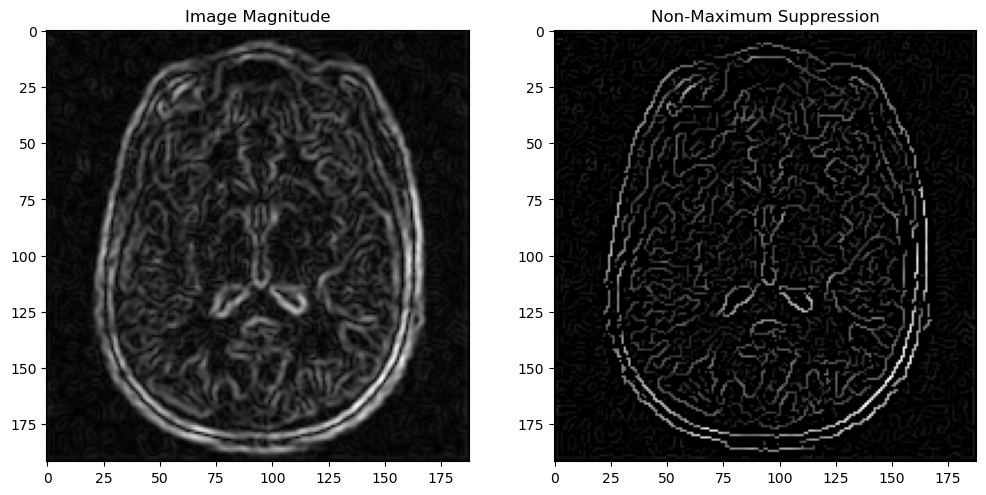

In [6]:
# ====== YOUR CODE: ======
non_max_img = non_max_suppression(img_magnitude, img_direction)

# Display
titles = ['Image Magnitude', 'Non-Maximum Suppression']
disp_img = [img_magnitude, non_max_img]

plt.figure(figsize=(12,12))
for i in range(2):
  plt.subplot(1, 2, i+1), plt.imshow(disp_img[i], cmap='gray'), plt.title(titles[i])

plt.show()
# ========================

5. After thinning the edges, we're left with high and low magnitude edges. We would like to filter out all the insignificant edges.
Implement the function `double_threshold` that gets an edge image and two thresholds and returns an image containing three values: 0 for background, 1 for weak edges, and 2 for strong edges.<br>
Write a description of your function and explain its inputs and output.

In [7]:
def double_threshold(edges: np.ndarray, lowThresholdRatio: float, highThresholdRatio: float) -> np.ndarray:
    '''
    This function gets two thresholds and quantifies the edge intensity 
    (background-0, weak-1, strong-2).

    :param edges: numpy array of an edge image after non max suppression
    :param lowThresholdRatio: the limit value between background and weak.
    :param highThresholdRatio: the limit value between weak and strong edges.
    :return img_tresh: numpy array containing the values 0, 1, 2.
    '''
    # ====== YOUR CODE: ======
    img_thresh = np.ones_like(edges)
    img_thresh[np.where(edges > highThresholdRatio)] = 2
    img_thresh[np.where(edges < lowThresholdRatio)] = 0
    # ========================
    return img_thresh

6. Use the above function to thin the edge map you computed in the previous part of this section.  Experiment to find good parameters of this operation. 
    Display in one figure the result produced by your `non_max_suppression` before applying `double_threshold`. Add titles to your figure.

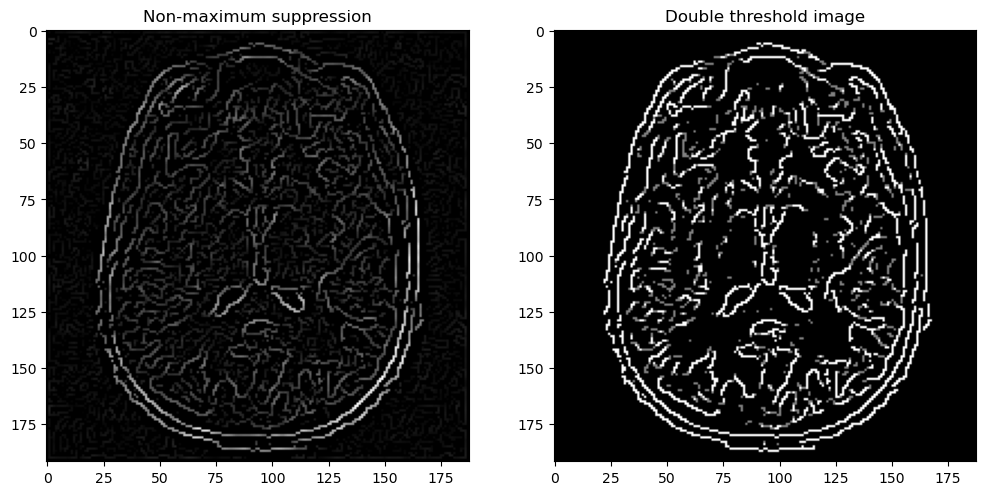

In [8]:
# ====== YOUR CODE: ======
lowThresholdRatio = 15  # can be changed
highThresholdRatio = 20  # can be changed
double_th_img = double_threshold(non_max_img, lowThresholdRatio, highThresholdRatio)

# Display
titles = ['Non-maximum suppression', 'Double threshold image']
disp_img = [non_max_img, double_th_img]

plt.figure(figsize=(12,12))
for i in range(2):
  plt.subplot(1, 2, i+1), plt.imshow(disp_img[i], cmap='gray'), plt.title(titles[i])

plt.show()
# ========================

7. The last step of Canny edge detector implementation is filtering the isolated weak edges and keeping only the strong edges and those that are connected to them. You can assume a neighborhood of 3X3. 
    Implement the function `hysteresis` that performs the describe above.  <br>
    Write a description of your function and explain its inputs and output.

In [9]:
def hysteresis(edges: np.ndarray) -> np.ndarray:
    '''
    This function filters the weak edges and keeps the strong edges and its
     weak-edged neighbors pixels.

    :param edges: 2d numpy array after double threshold
    :return hysteresis: 2d numpy array of a binary edge image.
    '''
    # ====== YOUR CODE: ======
    hysteresis = np.zeros_like(edges)

    for row in range(edges.shape[0]):
      for col in range(edges.shape[1]):
        if ((edges[row, col] == 2) or ((edges[row, col] == 1) and (2 in edges[row-1:row+2, col-1:col+2]))):
            hysteresis[row, col] = 2
    # ========================    
    return hysteresis

8. Let's get the final edges image of the brain. Take the thinned edge map you computed in the previous part of this section and use the `hysteresis` function to get the final edges image of the brain. Display in one figure the image before and after applying the hysteresis and titles. 


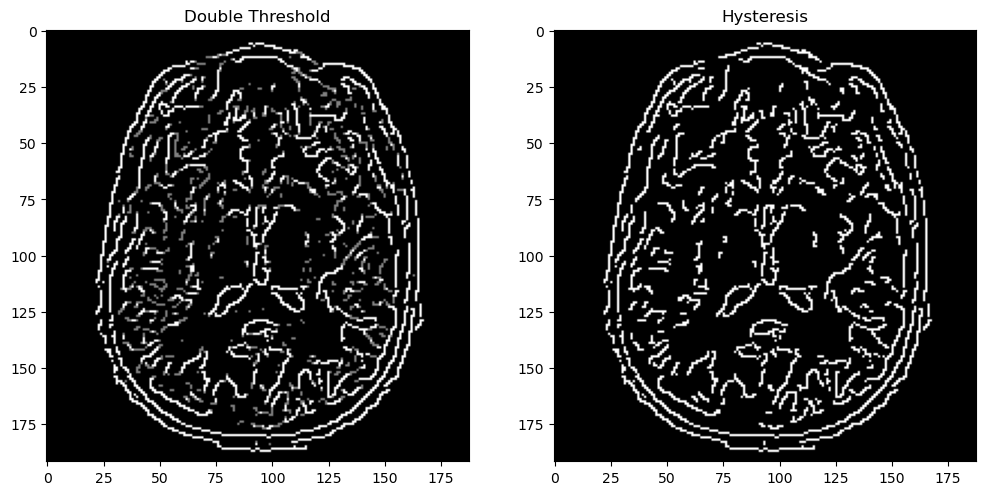

In [10]:
# ====== YOUR CODE: ======
hysteresis_img = hysteresis(double_th_img)

# Display
titles = ['Double Threshold', 'Hysteresis']
disp_img = [double_th_img, hysteresis_img]

plt.figure(figsize=(12,12))
for i in range(2):
  plt.subplot(1, 2, i+1), plt.imshow(disp_img[i], cmap='gray'), plt.title(titles[i])

plt.show()
# ========================

9. You used the Canny edge detector to get the edges of an image. However, you got an unsatisfied result; false edges appeared and long edges were broken into short ones separated by gaps. 
* How can you adjust the hysteresis thresholding to improve the edge detection.
* What could cause the false edges? Suggest a way to avoid the false edges (except to adjust the hysteresis thresholding)

    **Answer:** We can use a more accurate treshold by using statitical calculation, increase its range or the number of neighbor pixels we're checking. Noice or blured image can cause to differences between pixels values and to false edges detection. By filtereing the original image at the first step we may avoid the false edges.

---

## Exercise 2

In this exercise we will implement Hough Circle Transform.<br>
1. The first step we have to do is preprocess the image to get a binary image that represents its edges.<br>
    Load the image 'coins.jpg' and get its edges image using the `Canny` function of cv2 library. Display in one figure the original image and its edges and add titles. 

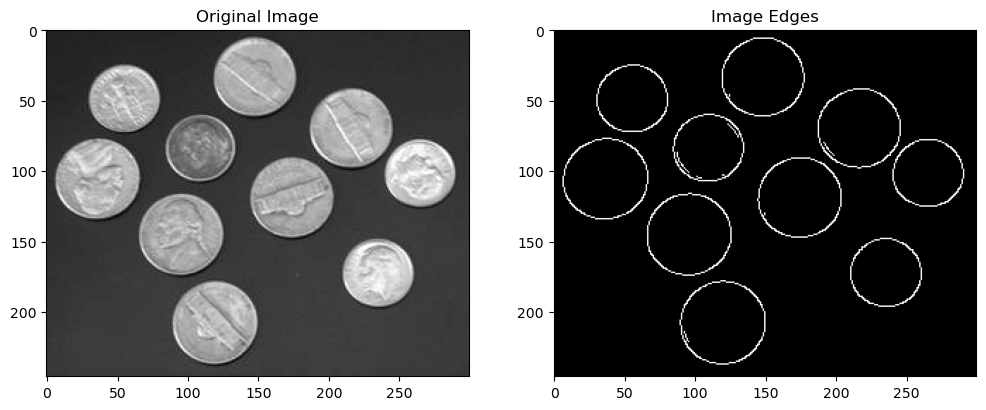

In [11]:
# ====== YOUR CODE: ======
coins_img = plt.imread('images/coins.jpg')
edges_img = cv2.Canny(coins_img, 300, 600)

# Display
titles = ['Original Image', 'Image Edges']
disp_img = [coins_img, edges_img]

plt.figure(figsize=(12,12))
for i in range(2):
  plt.subplot(1, 2, i+1), plt.imshow(disp_img[i], cmap='gray'), plt.title(titles[i])

plt.show()
# ========================

2. For Hough Circle Transform we need three parameters to define a circle: $(x_{center}, y_{center}, r)$ <br>
where $(x_{center},y_{center})$ define the center position and $r$ is the radius.
It means that in this case the accumolator matrix would be a 3D matrix.<br>
Implenent the function `circles_accumolator` that gets a binary image that repersents the image edges and an array of the different radiuses to search circles at, and return the accomultor matrix in the hough space. 


In [12]:
def circles_accumolator(img:np.ndarray, radius:np.ndarray)-> np.ndarray:
    '''
    This function gets an image edge and returns its hough transform 
    accumolation matrix

    :param edges: a binary image of the image edges
    :param radius: numpy array of different radiuses
    :return hough_domain: 3d accomultor matrix in the hough space
    '''
    # ====== YOUR CODE: ======
    hough_domain = np.zeros((img.shape[0]+1, img.shape[1]+1 ,np.max(radius)+1))
    edge = np.argwhere(img[:,:])
    angles_vec = (np.pi/180)*(np.arange(0, 360, 15))

    for i,j in edge:
        for r in radius:
            for theta in range(len(angles_vec)):
                a = int(i - r*np.cos(theta))
                b = int(j - r*np.sin(theta))
                if (0 <= a < img.shape[0]) and (0 <= b < img.shape[1]):
                    hough_domain[a,b,r] += 1

    # ========================    
    return hough_domain

4. Implement the function `hough_circles` that gets image of edges, computes the accomultor matrix in the hough space and return the parameters (a,b,r) of each detected circle on the image. Choose the detected circle acorrding to votes threshold and distance thresholds that represents the minimal distance between the centers of two different circles. 

In [13]:
def hough_circles(img:np.ndarray, radius:np.ndarray, votes_thresh:int, dist_thresh:float)-> np.ndarray:
    '''
    This function gets an edges image and return each detected circle's
     parameters (a,b,r) using the accomultor matrix in the hough space.

    :param edges: a binary image of the image edges
    :param radius: numpy array of different radiuses
    :param votes_thresh: minimal number of pixels that belong to a circle
    :param dist_thresh: minimal distance between two circle centers
    :return circles: numpy array of the circles parameters (a, b, r)
    '''
    # ====== YOUR CODE: ======
    hough_domain = circles_accumolator(img, radius)
    
    circles_above_th = np.asarray((np.where(hough_domain>votes_thresh))).T
    circle_x = circles_above_th[0]
    circle_x_mat = [circles_above_th[0]]
    init_idx = circles_above_th[0][0], circles_above_th[0][1], circles_above_th[0][2]
    c = 0

    for i in range(len(circles_above_th)-1):
      above_tresh = circles_above_th[i+1][0], circles_above_th[i+1][1], circles_above_th[i+1][2]
      distance = circle_x - above_tresh
      min_val = np.sqrt((distance[0])**2 + (distance[1])**2)
      circle_x = circles_above_th[i+1]

      if (min_val < dist_thresh) and (hough_domain[above_tresh] > hough_domain[init_idx]):
        circle_x_mat[c] = circles_above_th[i+1]
      else:
        circle_x_mat.append(circles_above_th[i+1])
        c += 1

    circles = np.array(circle_x_mat)     
    # ========================   
    return circles

5. Let's detect the coins in the image using your functions. Take the edges image of the coins, set the radius vector, votes threshold and distance thresholds, and get the detected circles parameters using the function `hough_circles`. Experiment to find the best parameters that yield the optimal coins detections. <br>
    Draw the detected circles on the original image of coins and display it in a figure. You may use the function `plt.Circle`. 

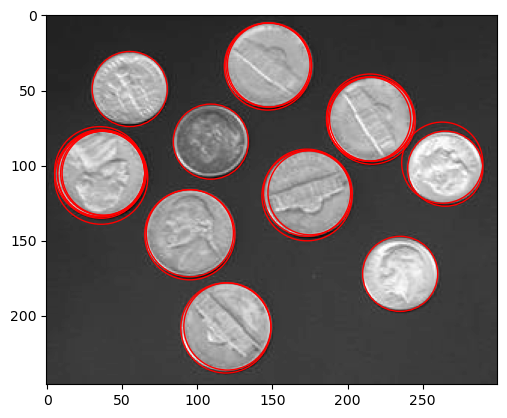

In [14]:
# ====== YOUR CODE: ======
radius = np.arange(25,50)
votes_thresh = 10
dist_thresh = 30
circles = hough_circles(edges_img, radius, votes_thresh, dist_thresh)
fig, ax = plt.subplots()
plt.imshow(coins_img, cmap='gray')
for i in range(len(circles)):
    circle = plt.Circle((circles[i,1], circles[i,0]), circles[i,2], color='r', fill=False)
    ax.add_patch(circle)
plt.show()
# ========================

6. **Bunos**<br>
5 points

    Implement the function `draw_circles` that draws a circle on a given image and plots the image with the circles (using only basic numpy functions).<br>
Use this function to draw the detected circles on the original image of coins and display it in a figure. 

In [15]:
def draw_circles(img:np.ndarray, circle_params:np.ndarray):
    '''
    This function gets an image and reutrn the image with circeled edges. 

    :param img: numpy array of an image
    :param circle_params: array of the circles parameters (a, b, r)
    '''
    # ====== YOUR CODE: ======      
    fig, ax = plt.subplots()
    plt.imshow(img, cmap='gray')
  
    angles = [np.arange(0, 2*np.pi ,0.0001)]
    theta_x = [np.cos(theta) for theta in angles]
    theta_y = [np.sin(theta) for theta in angles]

    for i in range(len(circle_params)):
        R = circle_params[i,2]    
        x = circle_params[i,1] + R*np.cos(theta_x)
        y = circle_params[i,0] + R*np.sin(theta_y)
        ax.plot(x, y, linestyle='solid', color='red')
    plt.show()
    # ========================   

    return

7. Given two points at (3,2) and (5,10) in the image space:
    * Describe the corresponding hough space of the parameters m,c.
    * Describe what the accumulator matrix would look like. Would you get a maximum in the matrix? If so,  where and what is the maximum value?  

**Answer:**

We will find the template of the lines which containing these points:

${2=m*3+c}$ and ${10=m*3+c}$

By comparing the lines we will get that range of hough spage is (c, m) = (-10, 4).

The accumulator matrix will get a value of 2, describing the the intersection point, which is also the maximum value, and all other points will get zeros. 